In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
import os
import sys

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/datasets".format(ROOT_DIR)
print(DATASET_DIR)

from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler, FunctionTransformer, scale

import torch
import torch.nn as nn
import torch.nn.functional as F # contains functional interface of typical operations used for building nn's
import torch.optim as optim     # contains optimizers e.g. Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix, Accuracy
from tqdm import tqdm

from lib import utilities

torch.set_printoptions(linewidth=120)

/home/jovyan/projects/djoy4stem/tox_21_qsar/datasets


/home/jovyan/envs/nlp_metabolizer/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs. Code written by Sovit Ranjan RathSovit Ranjan Rath 
    https://colab.research.google.com/drive/1krRZ-VVfpXUsHk3JFCjBtYUiUOwL8vW0?usp=sharing&pli=1&authuser=1#scrollTo=TBuoZ1PgK01f
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def return_binary_class_labels(predictions, threshold, pos_label=1):
    return (predictions>threshold).int()*pos_label
        
def loss_from_predictions (y_predicted, y_true, with_proba=True):
    if with_proba:        
        return torch.mean((y_true - y_predicted)**2).item()
    else:
        return torch.mean((y_true - torch.sigmoid(y_predicted))**2).item()

def fit_model(model, criterion, optimizer, train_loader, pos_label=1, threshold=0.5):
    """
    Fit the model, and compute loss and accuracy
    """
    running_loss = 0
    num_samples  = 0
    correct_predictions = 0
    model.train()
    for fps, labels in train_loader:
        # Training pass
        # (1) Initialize the gradients, which will be recorded during the forward pass
        optimizer.zero_grad()
        # (2) Forward pass of the mini-batch
        output = model(fps)
#         print("Output size: {}".format(output.shape))
#         print("Labels size: {}".format(labels.shape))
        # (3) Computing the loss
        loss = criterion(output, labels)
        # (4) Computes the gradient of current tensor w.r.t. graph leaves.
        loss.backward()
        # (5) Optimize the weights
        optimizer.step()
        running_loss += loss.item()          
        num_samples  += labels.size()[0]
        predicted_labels = return_binary_class_labels(output, threshold, pos_label)

        correct_predictions += (predicted_labels == labels).sum().item()         

    train_loss     = running_loss/len(train_loader)            
    train_accuracy = correct_predictions/num_samples
        
    return  train_loss, train_accuracy


def validate_model(model, criterion, optimizer, validation_loader, pos_label=1, threshold=0.5):
    """
    """
    running_loss = 0
    num_val_samples  = 0
    correct_predictions = 0
    model.eval()
    with torch.no_grad():
        for fps, labels in validation_loader:
            output = model(fps)
#             loss = criterion(output, labels)
#             running_loss += loss.item()            
            loss = loss_from_predictions (output, labels, with_proba=model.squash_output)
#             print("Loss: with criterion {} - With formula {}".format(criterion(output, labels), loss))
            running_loss += loss
            num_val_samples  += labels.size()[0]
            predicted_labels = return_binary_class_labels(output, threshold, pos_label)
            correct_predictions += (predicted_labels == labels).sum().item()
        
        validation_loss     = running_loss/len(validation_loader)            
        validation_accuracy = correct_predictions/num_val_samples   
    return validation_loss, validation_accuracy

def train_model(model, criterion, optimizer, n_epochs, train_loader, validation_loader, lr_scheduler=None, early_stopper=None, with_proba=True, pos_label=1, threshold=0.5):
    """
    Fit and validate model
    """
    train_losses, validation_losses, train_accuracies, validation_accuracies = [], [], [], []
    for e in tqdm(range(n_epochs),desc='Training'):
#         print("Epoch {} of {} epochs".format(e+1, n_epochs))
        train_loss, train_accuracy           = fit_model(model=model, criterion=criterion, optimizer=optimizer, train_loader=train_loader
                                                         , pos_label=pos_label, threshold=threshold)
        validation_loss, validation_accuracy = validate_model(model=model, criterion=criterion, optimizer=optimizer, validation_loader=validation_loader
                                                              , pos_label=pos_label, threshold=threshold)
 
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        if lr_scheduler is not None:
            lr_scheduler.step(validation_loss)
            
        if early_stopper is not None:
            early_stopper(validation_loss)
            if early_stopper.early_stop:
                break
        
        if e%10 == 0:
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(train_loss), validation_loss))
            print("Epoch: %3i Training accuracy: %0.2F Validation accuracy: %0.2F"%(e,(train_accuracy), validation_accuracy))
            

    
    return train_losses, validation_losses, train_accuracies, validation_accuracies


In [4]:
class ActivityNet(nn.Module):
    def __init__(self, n_inputs, hidden_size, dropout_rate, output_size, squash_output=True):
        super(ActivityNet, self).__init__()
        self.n_inputs = n_inputs
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.output_size = output_size
        self.squash_output = squash_output
        
        self.input_layer = nn.Linear(n_inputs, hidden_size)
        self.h1 = nn.Linear(hidden_size, hidden_size)
        self.h2 = nn.Linear(hidden_size, hidden_size)
        self.h3 = nn.Linear(hidden_size, hidden_size)
#         self.h4 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
             
        ## Add normalization
        ## In conclusion, Normalization layers in the model often helps to speed up and stabilize the learning process.
        ## https://towardsdatascience.com/different-normalization-layers-in-deep-learning-1a7214ff71d6#:~:text=In%20conclusion%2C%20Normalization%20layers%20in,Batch%20Normalization%20could%20be%20used.
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
#         self.ln4 = nn.LayerNorm(hidden_size)
        
        # Activation
        self.hl_activation = nn.LeakyReLU()
        if self.squash_output:
            self.ol_activation = nn.Sigmoid()
        
        # Regularization
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
#         self.dropout4 = nn.Dropout(dropout_rate)
       
    def forward(self, x):
        out = self.input_layer(x)
        out = self.ln1(out)
        out = self.h1(out)
        out = self.hl_activation(out)
        out = self.dropout1(out)
        out = self.ln2(out)
        out = self.h2(out)
        out = self.hl_activation(out)
        out = self.dropout2(out)
        out = self.ln3(out)
        out = self.h3(out)
        out = self.hl_activation(out)
        out = self.dropout3(out)
#         out = self.ln4(out)
#         out = self.h4(out)
#         out = self.hl_activation(out)
#         out = self.dropout4(out)
        out = self.output_layer(out)
        if self.squash_output:
            out = self.ol_activation(out)
        
        return out

# Dataset preparation

In [5]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.Chem import PandasTools, MolFromSmiles, AllChem, MolFromSmiles, Draw, MolToInchiKey, MolToSmiles
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

In [6]:
compounds_df = pd.read_csv("{}/compounds/nr-ahr.tab".format(ROOT_DIR), sep="\t")
compounds_df.shape, compounds_df.head()

((1900, 3),
           Compound                                             SMILES  \
 0  NCGC00013051-01                               CC(C)(C)c1cc(O)ccc1O   
 1  NCGC00013051-05                               CC(C)(C)c1cc(O)ccc1O   
 2  NCGC00013058-01   CN(C)c1ccc(cc1)C(c1ccccc1)=C1C=CC(C=C1)=[N+](C)C   
 3  NCGC00013260-01  COC(=O)[C@H]1[C@@H](O)CC[C@H]2CN3CCc4c5ccccc5[...   
 4  NCGC00013289-01                   OC(CCN1CCCCC1)(c1ccccc1)c1ccccc1   
 
    activity  
 0         1  
 1         1  
 2         1  
 3         1  
 4         1  )

In [7]:
molecule_column = 'Molecule'
smiles_column   = "SMILES"
inchikey_column = "Ambit_InchiKey"
target          = "activity"
PandasTools.AddMoleculeColumnToFrame(compounds_df,'SMILES',molecule_column, includeFingerprints=True)
compounds_df.Molecule.isna().sum(), compounds_df.iloc[:1,:]

(0,
           Compound                SMILES  activity  \
 0  NCGC00013051-01  CC(C)(C)c1cc(O)ccc1O         1   
 
                                             Molecule  
 0  <img data-content="rdkit/molecule" src="data:i...  )

## Removing duplicates
For several compounds (referrenced by Ambit_inchikeys) there are more than one rows. The target values will be averaged.

In [8]:
if not inchikey_column in compounds_df.columns:
    print("Computing and storing the InChiKeys...")
    compounds_df[inchikey_column] = compounds_df[molecule_column].apply(lambda x: MolToInchiKey(x))

Computing and storing the InChiKeys...


In [9]:
compounds_df = utilities.remove_conflicting_target_values(compounds_df, target, inchikey_column)
compounds_df.shape, compounds_df.head(1)

InchIKey CYMPUOGZUXAIMY-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey GZPHSAQLYPIAIN-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey JJYPMNFTHPTTDI-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey MACXEFYJKXWDCK-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey MVWVFYHBGMAFLY-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey VMPITZXILSNTON-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey WYWZRNAHINYAEF-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.


((1663, 5),
             Compound                                        SMILES  activity  \
 390  NCGC00164574-01  COCCOc1cc2[n]c[n]c(Nc3cc(ccc3)C#C)c2cc1OCCOC         1   
 
                                               Molecule  \
 390  <img data-content="rdkit/molecule" src="data:i...   
 
                   Ambit_InchiKey  
 390  AAKJLRGGTJKAMG-UHFFFAOYSA-N  )

## MinMax Picking Train/Validate/Test Split
Reference(s):
>- **Picking Diverse Molecules Using Fingerprints (rdkit.SimDivFilters):** https://www.rdkit.org/docs/GettingStartedInPython.html
>- **Squonk: RDKit MaxMin Picker:** https://squonk.it/docs/cells/RDKit%20MaxMin%20Picker/
>- **Revisting the MaxMinPicker (2017)** http://rdkit.blogspot.com/2017/11/revisting-maxminpicker.html
>- **RDKit Blog - MaxMinPicker**: https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/MaxMinPickerRevisited.ipynb

### MinMax Picking with Morgan Fingperprints

In [10]:
%%time
compounds_train, compounds_validation, compounds_test = utilities.min_max_train_validate_test_split_df(compounds_df, molecule_column
                                                    , inchikey_column=None, train_valid_ratios=[0.7, 0.20], fp_type= "morgan"
                                                    , fp_column=None, random_state=1, return_indices=False)

Computing and storing the InChiKeys...
Splitting the dataset...
1164 - 333 - 166
Indices (training):1164 - [693, 10]
Indices (validation):333 - [720]
Indices (test):166 - [24]
Train: (1164, 6) - Validate: (333, 6) - Test: (166, 6)
Index(['Compound', 'SMILES', 'activity', 'Molecule', 'Ambit_InchiKey',
       'InChIKey'],
      dtype='object')
CPU times: user 3.22 s, sys: 2.45 ms, total: 3.22 s
Wall time: 3.34 s


## Prepare data
We will compute hashed morgan fingerprints, perform featire selection, and scale the target values.

(1164, 7)
(166, 7)


/home/jovyan/envs/nlp_metabolizer/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jovyan/envs/nlp_metabolizer/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jovyan/envs/nlp_metabolizer/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Compound,SMILES,activity,Molecule,Ambit_InchiKey,InChIKey,FPs
390,NCGC00164574-01,COCCOc1cc2[n]c[n]c(Nc3cc(ccc3)C#C)c2cc1OCCOC,1,,AAKJLRGGTJKAMG-UHFFFAOYSA-N,AAKJLRGGTJKAMG-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, ..."

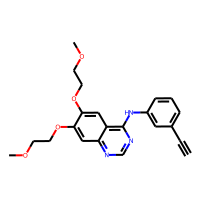

In [11]:
compounds_train["FPs"]       = compounds_train["Molecule"].apply(utilities.mol2fp)
compounds_validation["FPs"]  = compounds_validation["Molecule"].apply(utilities.mol2fp)
compounds_test["FPs"]        = compounds_test["Molecule"].apply(utilities.mol2fp)
print(compounds_train.shape)
print(compounds_test.shape)
compounds_train.head(1)

In [12]:
X_train       = np.stack(compounds_train.FPs.values)
y_train       = compounds_train.activity.values.reshape((-1,1))
X_validation  = np.stack(compounds_validation.FPs.values)
y_validation  = compounds_validation.activity.values.reshape((-1,1))
X_test        = np.stack(compounds_test.FPs.values)
y_test        = compounds_test.activity.values.reshape((-1,1))
X_train.shape, X_validation.shape, X_test.shape

((1164, 4096), (333, 4096), (166, 4096))

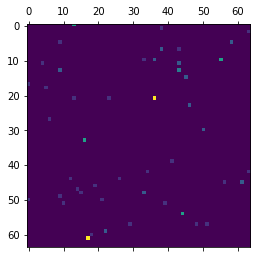

In [13]:
plt.matshow(X_train[0].reshape((64,-1)), )

# Learning
<strong>Loss functions</strong> \
We will use two different loss functions, namely, the BCE Loss and the BCEWithLogitsLoss functions. The difference between nn.BCEWithLogitsLoss and nn.BCELoss is that BCE with Logits loss adds the Sigmoid function into the loss function. With simple BCE Loss, you will have to add Sigmoid to the neural network, whereas with BCE With Logits Loss you will not. The BCEWithLogitsLoss is generally more stable and thus recommended.

>- https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-pytorch-loss-functions.md
>- https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations

**Statistics report** \
We will compute the confusion matrix and accuracy on the train/validate/test sets.
>- https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html
>- https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html

**Early stopping and learning rate scheduler** <!-- No \ symbol after, since there is no sentence right after-->

>- https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
>- https://pythonguides.com/pytorch-early-stopping/
>- https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau

A helpful library for implementing LR and ES is torchsample, which can be found on [GitHub](https://github.com/ncullen93/torchsample). An example of how to use it is described [here](https://medium.com/analytics-vidhya/early-stopping-with-pytorch-to-restrain-your-model-from-overfitting-dce6de4081c5). But we will use a much simpler implementation.

In [14]:
# Let's get those arrays transfered to the GPU memory as tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = 'cpu'

X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cuda:0


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [15]:
y_train.shape

torch.Size([1164, 1])

\
If you run into <em>"RuntimeError: CUDA error: device-side assert triggered"</em>, it is possible that the notebook  is running out of GPU memory. This can sometimes happen when you rerun some of the cells but the memory  is not properly released beforehand. 
1. Try using the CPU to see if the problem still exists
2. Check your labels, i.e.: "whether -1 exists in the labels of the training data"

References:
>- https://pycad.co/runtimeerror-cuda-error-device-side-assert-triggered/
>- https://github.com/deepset-ai/haystack/issues/1833
>- https://clay-atlas.com/us/blog/2021/06/23/linux-en-machine-learning-pytorch-cuda-error-device-side-assert/

In [16]:
X_train.shape

torch.Size([1164, 4096])

Pytorch work with datasets and dataloaders to feed the minibatches to the model during training, so we convert the data. It’s easy to create a dataset from the already created tensors. The batch size is set to 256 and the trainloader will shuffle the data when an epoch has been used.

In [17]:
from torch.utils.data import TensorDataset

batch_size=128
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
X_train.shape, X_train.shape[0]/batch_size, len(train_loader)

(torch.Size([1164, 4096]), 9.09375, 10)

In [18]:
n_inputs      = X_train.size()[-1] # The input size should fit our fingerprint size
hidden_size   = 1024   # The size of the hidden layer
dropout_rate  = 0.70    # The dropout rate
output_size   = 1        # This is just a single task, so this will be one
learning_rate = 0.001  # The learning rate for the optimizer
n_epochs      = 500
lr_patience  = 30
es_patience  = 50 # Make sure that the patience for early stopping is larger than the learning rate scheduler patience
early_stopper = EarlyStopping(min_delta=0.00001, patience = es_patience)

## Using BCELoss

In [19]:
model        = ActivityNet(n_inputs, hidden_size, dropout_rate, output_size, squash_output=True).to(device=device) # Returns a Tensor with the specified device
optimizer    = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion    = nn.BCELoss() # De facto for binary classification
# A values above the threshold are classified into category pos_label (usually 1)
# , and those below 0.5 are classified into value 0
threshold    = torch.tensor([0.5]).to(device) 

# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5
                                 , patience=lr_patience # Number of epochs with no improvement after which learning rate will be reduced
                                 , verbose=True
                                 , threshold=0.0001
                                 , threshold_mode='rel', cooldown=0, min_lr=learning_rate, eps=1e-08)

Training:   1%|          | 3/500 [00:00<01:00,  8.24it/s]

Epoch:   0 Training loss: 0.72 Validation loss: 0.24
Epoch:   0 Training accuracy: 0.50 Validation accuracy: 0.65


Training:   2%|▏         | 8/500 [00:00<00:32, 15.06it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50


Training:   3%|▎         | 14/500 [00:00<00:25, 18.93it/s]

INFO: Early stopping counter 6 of 50
Epoch:  10 Training loss: 0.60 Validation loss: 0.18
Epoch:  10 Training accuracy: 0.68 Validation accuracy: 0.77
INFO: Early stopping counter 7 of 50
INFO: Early stopping counter 8 of 50
INFO: Early stopping counter 9 of 50
INFO: Early stopping counter 10 of 50


Training:   4%|▍         | 20/500 [00:01<00:23, 20.56it/s]

INFO: Early stopping counter 11 of 50
INFO: Early stopping counter 12 of 50
INFO: Early stopping counter 13 of 50
INFO: Early stopping counter 14 of 50
INFO: Early stopping counter 15 of 50


Training:   5%|▍         | 23/500 [00:01<00:22, 21.02it/s]

INFO: Early stopping counter 16 of 50
Epoch:  20 Training loss: 0.54 Validation loss: 0.19
Epoch:  20 Training accuracy: 0.71 Validation accuracy: 0.78
INFO: Early stopping counter 17 of 50
INFO: Early stopping counter 18 of 50
INFO: Early stopping counter 19 of 50
INFO: Early stopping counter 20 of 50


Training:   6%|▌         | 29/500 [00:01<00:21, 21.54it/s]

INFO: Early stopping counter 21 of 50
INFO: Early stopping counter 22 of 50
INFO: Early stopping counter 23 of 50
INFO: Early stopping counter 24 of 50
INFO: Early stopping counter 25 of 50


Training:   6%|▋         | 32/500 [00:01<00:21, 21.69it/s]

INFO: Early stopping counter 26 of 50
Epoch:  30 Training loss: 0.49 Validation loss: 0.17
Epoch:  30 Training accuracy: 0.75 Validation accuracy: 0.80
INFO: Early stopping counter 27 of 50
INFO: Early stopping counter 28 of 50
INFO: Early stopping counter 29 of 50


Training:   8%|▊         | 38/500 [00:02<00:24, 19.17it/s]

INFO: Early stopping counter 30 of 50
INFO: Early stopping counter 1 of 50


Training:   8%|▊         | 40/500 [00:02<00:27, 16.89it/s]

INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
Epoch:  40 Training loss: 0.44 Validation loss: 0.16
Epoch:  40 Training accuracy: 0.78 Validation accuracy: 0.81


Training:   9%|▉         | 46/500 [00:02<00:23, 19.22it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 1 of 50


Training:  10%|█         | 52/500 [00:02<00:21, 20.59it/s]

INFO: Early stopping counter 1 of 50
Epoch:  50 Training loss: 0.42 Validation loss: 0.15
Epoch:  50 Training accuracy: 0.80 Validation accuracy: 0.81


Training:  11%|█         | 55/500 [00:02<00:21, 21.01it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50


Training:  12%|█▏        | 61/500 [00:03<00:20, 21.37it/s]

INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 1 of 50
Epoch:  60 Training loss: 0.41 Validation loss: 0.14
Epoch:  60 Training accuracy: 0.84 Validation accuracy: 0.82
INFO: Early stopping counter 2 of 50


Training:  13%|█▎        | 67/500 [00:03<00:19, 21.69it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 1 of 50


Training:  15%|█▍        | 73/500 [00:03<00:19, 21.87it/s]

INFO: Early stopping counter 1 of 50
Epoch:  70 Training loss: 0.36 Validation loss: 0.13
Epoch:  70 Training accuracy: 0.85 Validation accuracy: 0.85
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50


Training:  16%|█▌        | 79/500 [00:04<00:19, 21.99it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
Epoch:  80 Training loss: 0.28 Validation loss: 0.13
Epoch:  80 Training accuracy: 0.88 Validation accuracy: 0.84


Training:  17%|█▋        | 85/500 [00:04<00:18, 22.05it/s]

INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50
INFO: Early stopping counter 6 of 50
INFO: Early stopping counter 7 of 50


Training:  18%|█▊        | 91/500 [00:04<00:18, 22.03it/s]

INFO: Early stopping counter 8 of 50
INFO: Early stopping counter 9 of 50
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
Epoch:  90 Training loss: 0.28 Validation loss: 0.11
Epoch:  90 Training accuracy: 0.88 Validation accuracy: 0.86


Training:  19%|█▉        | 94/500 [00:04<00:18, 22.05it/s]

INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50


Training:  20%|██        | 100/500 [00:04<00:18, 22.09it/s]

INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50
INFO: Early stopping counter 6 of 50
INFO: Early stopping counter 7 of 50
INFO: Early stopping counter 8 of 50
Epoch: 100 Training loss: 0.23 Validation loss: 0.11
Epoch: 100 Training accuracy: 0.91 Validation accuracy: 0.87


Training:  21%|██        | 106/500 [00:05<00:17, 21.99it/s]

INFO: Early stopping counter 9 of 50
INFO: Early stopping counter 10 of 50
INFO: Early stopping counter 11 of 50
INFO: Early stopping counter 12 of 50
INFO: Early stopping counter 13 of 50


Training:  22%|██▏       | 109/500 [00:05<00:17, 21.99it/s]

INFO: Early stopping counter 14 of 50
INFO: Early stopping counter 15 of 50
INFO: Early stopping counter 16 of 50
INFO: Early stopping counter 17 of 50


Training:  23%|██▎       | 115/500 [00:05<00:18, 21.16it/s]

INFO: Early stopping counter 18 of 50
Epoch: 110 Training loss: 0.14 Validation loss: 0.12
Epoch: 110 Training accuracy: 0.94 Validation accuracy: 0.87
INFO: Early stopping counter 19 of 50
INFO: Early stopping counter 20 of 50
INFO: Early stopping counter 21 of 50
INFO: Early stopping counter 22 of 50


Training:  24%|██▎       | 118/500 [00:05<00:19, 19.37it/s]

INFO: Early stopping counter 23 of 50
INFO: Early stopping counter 24 of 50
INFO: Early stopping counter 25 of 50


Training:  24%|██▍       | 122/500 [00:06<00:21, 17.57it/s]

INFO: Early stopping counter 26 of 50
INFO: Early stopping counter 27 of 50
INFO: Early stopping counter 28 of 50
Epoch: 120 Training loss: 0.15 Validation loss: 0.11
Epoch: 120 Training accuracy: 0.95 Validation accuracy: 0.88
INFO: Early stopping counter 29 of 50


Training:  25%|██▌       | 125/500 [00:06<00:19, 18.81it/s]

INFO: Early stopping counter 30 of 50
INFO: Early stopping counter 31 of 50
INFO: Early stopping counter 32 of 50
INFO: Early stopping counter 33 of 50
INFO: Early stopping counter 34 of 50


Training:  26%|██▌       | 131/500 [00:06<00:18, 20.39it/s]

INFO: Early stopping counter 35 of 50
INFO: Early stopping counter 36 of 50
INFO: Early stopping counter 37 of 50
INFO: Early stopping counter 38 of 50
Epoch: 130 Training loss: 0.15 Validation loss: 0.12
Epoch: 130 Training accuracy: 0.94 Validation accuracy: 0.86
INFO: Early stopping counter 39 of 50


Training:  27%|██▋       | 137/500 [00:06<00:17, 21.19it/s]

INFO: Early stopping counter 40 of 50
INFO: Early stopping counter 41 of 50
INFO: Early stopping counter 42 of 50
INFO: Early stopping counter 43 of 50


Training:  28%|██▊       | 140/500 [00:06<00:16, 21.40it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
Epoch: 140 Training loss: 0.07 Validation loss: 0.13
Epoch: 140 Training accuracy: 0.97 Validation accuracy: 0.86
INFO: Early stopping counter 5 of 50


Training:  29%|██▉       | 146/500 [00:07<00:16, 21.65it/s]

INFO: Early stopping counter 6 of 50
INFO: Early stopping counter 7 of 50
INFO: Early stopping counter 8 of 50
INFO: Early stopping counter 9 of 50
INFO: Early stopping counter 10 of 50


Training:  30%|███       | 152/500 [00:07<00:15, 21.79it/s]

INFO: Early stopping counter 11 of 50
INFO: Early stopping counter 12 of 50
INFO: Early stopping counter 13 of 50
INFO: Early stopping counter 14 of 50
Epoch: 150 Training loss: 0.04 Validation loss: 0.12
Epoch: 150 Training accuracy: 0.99 Validation accuracy: 0.87
INFO: Early stopping counter 15 of 50


Training:  31%|███       | 155/500 [00:07<00:15, 21.82it/s]

INFO: Early stopping counter 16 of 50
INFO: Early stopping counter 17 of 50
INFO: Early stopping counter 18 of 50
INFO: Early stopping counter 19 of 50
INFO: Early stopping counter 20 of 50


Training:  32%|███▏      | 161/500 [00:07<00:15, 21.87it/s]

INFO: Early stopping counter 21 of 50
INFO: Early stopping counter 22 of 50
INFO: Early stopping counter 23 of 50
INFO: Early stopping counter 24 of 50
Epoch: 160 Training loss: 0.03 Validation loss: 0.15
Epoch: 160 Training accuracy: 0.99 Validation accuracy: 0.84
INFO: Early stopping counter 25 of 50


Training:  33%|███▎      | 167/500 [00:08<00:15, 21.89it/s]

INFO: Early stopping counter 26 of 50
INFO: Early stopping counter 27 of 50
INFO: Early stopping counter 28 of 50
INFO: Early stopping counter 29 of 50
INFO: Early stopping counter 30 of 50


Training:  34%|███▍      | 170/500 [00:08<00:15, 21.91it/s]

INFO: Early stopping counter 31 of 50
INFO: Early stopping counter 32 of 50
INFO: Early stopping counter 33 of 50
INFO: Early stopping counter 34 of 50
Epoch: 170 Training loss: 0.02 Validation loss: 0.11
Epoch: 170 Training accuracy: 0.99 Validation accuracy: 0.88
INFO: Early stopping counter 35 of 50


Training:  35%|███▌      | 176/500 [00:08<00:14, 21.90it/s]

INFO: Early stopping counter 36 of 50
INFO: Early stopping counter 37 of 50
INFO: Early stopping counter 38 of 50
INFO: Early stopping counter 39 of 50
INFO: Early stopping counter 40 of 50


Training:  36%|███▋      | 182/500 [00:08<00:14, 21.91it/s]

INFO: Early stopping counter 41 of 50
INFO: Early stopping counter 42 of 50
INFO: Early stopping counter 43 of 50
INFO: Early stopping counter 44 of 50
Epoch: 180 Training loss: 0.03 Validation loss: 0.13
Epoch: 180 Training accuracy: 0.99 Validation accuracy: 0.86
INFO: Early stopping counter 45 of 50


Training:  37%|███▋      | 186/500 [00:09<00:15, 20.41it/s]

INFO: Early stopping counter 46 of 50
INFO: Early stopping counter 47 of 50
INFO: Early stopping counter 48 of 50
INFO: Early stopping counter 49 of 50
INFO: Early stopping counter 50 of 50
INFO: Early stopping

Saving loss and accuracy plots...


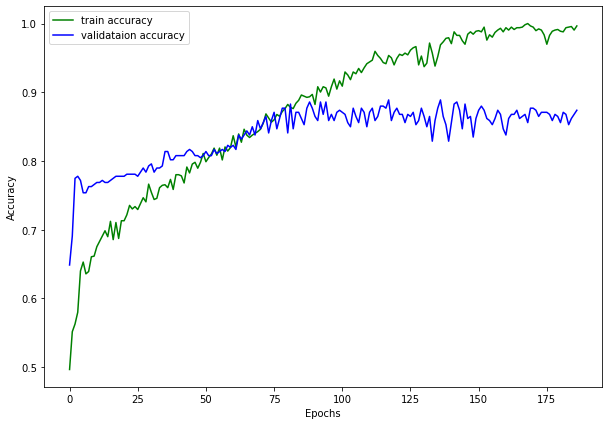

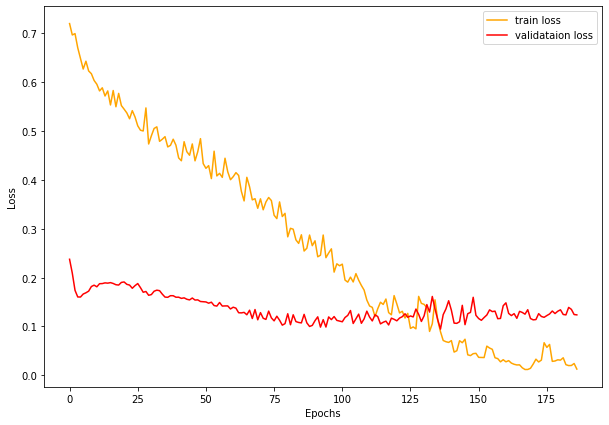

CPU times: user 9.14 s, sys: 377 ms, total: 9.52 s
Wall time: 9.72 s


In [20]:
%%time
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model=model, criterion=criterion, optimizer=optimizer, n_epochs=n_epochs
                                                                                     , train_loader=train_loader, validation_loader=validation_loader
                                                                                     , lr_scheduler=lr_scheduler, early_stopper=early_stopper
                                                                                     , pos_label=1, threshold=threshold)

print('\nSaving loss and accuracy plots...')
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracies, color='green', label='train accuracy')
plt.plot(validation_accuracies, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("{}/figures/Accuracies by epoch".format(ROOT_DIR))
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='orange', label='train loss')
plt.plot(validation_losses, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("{}/figures/Losses by epoch".format(ROOT_DIR))
plt.show()

In [21]:
model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)
print("y_validation: {} - y_pred_validation: {}".format(y_validation.shape, y_pred_validation.shape))
# print(y_validation)
# criterion(y_pred_train, y_train), criterion(y_pred_validation, y_validation).item(), criterion(y_pred_test, y_test).item()
"Train: {}".format(torch.mean(( y_validation - torch.sigmoid(y_pred_validation) )**2).item()), "Validation: {}".format(torch.mean(( y_validation - torch.sigmoid(y_pred_validation) )**2).item()), "Test: {}".format(torch.mean(( y_test - torch.sigmoid(y_pred_test) )**2).item())


y_validation: torch.Size([333, 1]) - y_pred_validation: torch.Size([333, 1])


('Train: 0.18601283431053162',
 'Validation: 0.18601283431053162',
 'Test: 0.20600226521492004')

In [22]:
print(y_pred_train.reshape(-1).detach().to('cpu'))
print(y_train.reshape(-1).detach().to('cpu'))

pos_label = 1

train_results      = return_binary_class_labels(predictions=y_pred_train, threshold=threshold, pos_label=pos_label)
validation_results = return_binary_class_labels(predictions=y_pred_validation, threshold=threshold, pos_label=pos_label)
test_results       = return_binary_class_labels(predictions=y_pred_test, threshold=threshold, pos_label=pos_label)

print("validation_results: {}".format(validation_results.shape))

tensor([1.0000e+00, 2.7249e-11, 5.6795e-07,  ..., 1.0000e+00, 1.0000e+00, 3.2452e-12])
tensor([1., 0., 0.,  ..., 1., 1., 0.])
validation_results: torch.Size([333, 1])


#### Compute confusion matrix and accuray

In [23]:
confmat = ConfusionMatrix(num_classes=2)
cmat_train      = confmat(train_results.to('cpu'), y_train.int().to('cpu'))
cmat_validation = confmat(validation_results.to('cpu'), y_validation.int().to('cpu'))
cmat_test       = confmat(test_results.to('cpu'), y_test.int().to('cpu'))
accuracy = Accuracy(num_classes=2)
accuracy_train      = accuracy(train_results.int().to('cpu'), y_train.int().to('cpu'))
accuracy_validation = accuracy(validation_results.int().to('cpu'), y_validation.int().to('cpu'))
accuracy_test       = accuracy(test_results.int().to('cpu'), y_test.int().to('cpu'))


# "Train: {}".format(cmat_train), "Validation: {}".format(cmat_validation), "Test: {}".format(cmat_test)
"Train", cmat_train, "Validation", cmat_validation, "Test", cmat_test, "Train: {} - Validation: {} - Test: {}".format(round(float(accuracy_train), 3)
                                               , round(float(accuracy_validation), 3)
                                               ,  round(float(accuracy_test), 3))

('Train',
 tensor([[664,   1],
         [  0, 499]]),
 'Validation',
 tensor([[132,  24],
         [ 18, 159]]),
 'Test',
 tensor([[71, 17],
         [11, 67]]),
 'Train: 0.999 - Validation: 0.874 - Test: 0.831')

## Using BCEWithLogitsLoss
Computing the binary loss by providing the logits, and not the class probabilities is usually preferred due to numerical stability.\
Using BCEWithLogitsLoss: BCEWithLogitsLoss takes predictions that are raw-score logits (those produced by your final layer assuming it not transformed using an activation function values run that run from -inf to inf) and compares them with ground-truth labels that are zeros and ones (or more generally, with ground-truth labels that are probabilities between zero and one). Thus, if we use BCEWithLogitsLoss, we are not converting the predictions (that are logits) into zeros and ones before passing them to BCEWithLogitsLoss.\
BCEWithLogitsLoss return logits during inference, the values of the logits might be harder to interpret, so you need to apply a sigmoid to get the probabilities. If you don't need the probabilities to get the predictions from logits, you could apply a threshold (e.g. out > 0.0) for a binary and multi-label classification with CrossEntropyLoss you could apply argmax(output, dim=1).

References:
>- https://androidkt.com/difference-between-bceloss-and-bcewithlogitsloss-in-pytorch/
>- https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations

In [23]:
X_train       = np.stack(compounds_train.FPs.values)
y_train       = compounds_train.activity.values.reshape((-1,1))
X_validation  = np.stack(compounds_validation.FPs.values)
y_validation  = compounds_validation.activity.values.reshape((-1,1))
X_test        = np.stack(compounds_test.FPs.values)
y_test        = compounds_test.activity.values.reshape((-1,1))
X_train.shape, X_validation.shape, X_test.shape

X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [24]:
criterion = nn.BCEWithLogitsLoss() # De facto for binary classification
model_bcewl = ActivityNet(n_inputs, hidden_size, dropout_rate, output_size, squash_output=False).to(device=device) # Returns a Tensor with the specified device
optimizer = optim.SGD(model_bcewl.parameters(), lr=learning_rate, momentum=0.9)
threshold    = torch.tensor([0.0]).to(device)
early_stopper = EarlyStopping(min_delta=0.00001, patience = es_patience)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5
                                 , patience=lr_patience # Number of epochs with no improvement after which learning rate will be reduced
                                 , verbose=True
                                 , threshold=0.0001
                                 , threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

Training:   1%|          | 3/500 [00:00<00:22, 21.98it/s]

Epoch:   0 Training loss: 0.75 Validation loss: 0.24
Epoch:   0 Training accuracy: 0.46 Validation accuracy: 0.52
INFO: Early stopping counter 1 of 50


Training:   2%|▏         | 9/500 [00:00<00:22, 21.98it/s]

INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50


Training:   3%|▎         | 15/500 [00:00<00:21, 22.06it/s]

INFO: Early stopping counter 4 of 50
Epoch:  10 Training loss: 0.60 Validation loss: 0.19
Epoch:  10 Training accuracy: 0.68 Validation accuracy: 0.77
INFO: Early stopping counter 5 of 50
INFO: Early stopping counter 6 of 50
INFO: Early stopping counter 7 of 50
INFO: Early stopping counter 8 of 50


Training:   4%|▎         | 18/500 [00:00<00:21, 22.13it/s]

INFO: Early stopping counter 9 of 50
INFO: Early stopping counter 10 of 50
INFO: Early stopping counter 11 of 50
INFO: Early stopping counter 12 of 50
INFO: Early stopping counter 13 of 50


Training:   5%|▍         | 24/500 [00:01<00:21, 22.19it/s]

INFO: Early stopping counter 14 of 50
Epoch:  20 Training loss: 0.52 Validation loss: 0.18
Epoch:  20 Training accuracy: 0.73 Validation accuracy: 0.77
INFO: Early stopping counter 15 of 50
INFO: Early stopping counter 16 of 50
INFO: Early stopping counter 17 of 50
INFO: Early stopping counter 18 of 50


Training:   6%|▌         | 30/500 [00:01<00:21, 22.11it/s]

INFO: Early stopping counter 19 of 50
INFO: Early stopping counter 20 of 50
INFO: Early stopping counter 21 of 50
INFO: Early stopping counter 22 of 50
INFO: Early stopping counter 23 of 50


Training:   7%|▋         | 33/500 [00:01<00:21, 22.11it/s]

INFO: Early stopping counter 24 of 50
Epoch:  30 Training loss: 0.52 Validation loss: 0.17
Epoch:  30 Training accuracy: 0.74 Validation accuracy: 0.79
INFO: Early stopping counter 25 of 50
INFO: Early stopping counter 26 of 50


Training:   8%|▊         | 39/500 [00:01<00:20, 22.21it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50


Training:   9%|▉         | 45/500 [00:02<00:20, 21.75it/s]

Epoch:  40 Training loss: 0.48 Validation loss: 0.15
Epoch:  40 Training accuracy: 0.78 Validation accuracy: 0.82
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 1 of 50


Training:  10%|█         | 51/500 [00:02<00:24, 18.34it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 1 of 50
Epoch:  50 Training loss: 0.42 Validation loss: 0.14
Epoch:  50 Training accuracy: 0.81 Validation accuracy: 0.83


Training:  11%|█▏        | 57/500 [00:02<00:22, 20.11it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 1 of 50


Training:  13%|█▎        | 63/500 [00:02<00:20, 21.16it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
Epoch:  60 Training loss: 0.48 Validation loss: 0.13
Epoch:  60 Training accuracy: 0.81 Validation accuracy: 0.84


Training:  13%|█▎        | 66/500 [00:03<00:20, 21.46it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50


Training:  14%|█▍        | 72/500 [00:03<00:19, 21.86it/s]

INFO: Early stopping counter 1 of 50
Epoch:  70 Training loss: 0.34 Validation loss: 0.10
Epoch:  70 Training accuracy: 0.86 Validation accuracy: 0.87
INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50


Training:  16%|█▌        | 78/500 [00:03<00:19, 22.04it/s]

INFO: Early stopping counter 1 of 50
INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 1 of 50


Training:  17%|█▋        | 84/500 [00:03<00:18, 22.13it/s]

INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
Epoch:  80 Training loss: 0.30 Validation loss: 0.10
Epoch:  80 Training accuracy: 0.87 Validation accuracy: 0.87
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50
INFO: Early stopping counter 6 of 50


Training:  17%|█▋        | 87/500 [00:04<00:18, 22.15it/s]

INFO: Early stopping counter 7 of 50
INFO: Early stopping counter 8 of 50
INFO: Early stopping counter 9 of 50
INFO: Early stopping counter 10 of 50
INFO: Early stopping counter 11 of 50


Training:  19%|█▊        | 93/500 [00:04<00:18, 22.15it/s]

INFO: Early stopping counter 12 of 50
INFO: Early stopping counter 13 of 50
Epoch:  90 Training loss: 0.27 Validation loss: 0.12
Epoch:  90 Training accuracy: 0.88 Validation accuracy: 0.85
INFO: Early stopping counter 14 of 50
INFO: Early stopping counter 15 of 50
INFO: Early stopping counter 16 of 50


Training:  20%|█▉        | 99/500 [00:04<00:18, 21.96it/s]

INFO: Early stopping counter 17 of 50
INFO: Early stopping counter 18 of 50
INFO: Early stopping counter 19 of 50
INFO: Early stopping counter 20 of 50
INFO: Early stopping counter 21 of 50


Training:  20%|██        | 102/500 [00:04<00:18, 21.99it/s]

INFO: Early stopping counter 22 of 50
INFO: Early stopping counter 23 of 50
Epoch: 100 Training loss: 0.19 Validation loss: 0.11
Epoch: 100 Training accuracy: 0.92 Validation accuracy: 0.88
INFO: Early stopping counter 24 of 50
INFO: Early stopping counter 25 of 50
INFO: Early stopping counter 26 of 50


Training:  22%|██▏       | 108/500 [00:04<00:17, 22.05it/s]

INFO: Early stopping counter 27 of 50
INFO: Early stopping counter 28 of 50
INFO: Early stopping counter 29 of 50
INFO: Early stopping counter 30 of 50
Epoch   109: reducing learning rate of group 0 to 5.0000e-04.
INFO: Early stopping counter 31 of 50


Training:  23%|██▎       | 114/500 [00:05<00:17, 22.09it/s]

INFO: Early stopping counter 32 of 50
INFO: Early stopping counter 33 of 50
Epoch: 110 Training loss: 0.17 Validation loss: 0.11
Epoch: 110 Training accuracy: 0.94 Validation accuracy: 0.87
INFO: Early stopping counter 34 of 50
INFO: Early stopping counter 35 of 50
INFO: Early stopping counter 36 of 50


Training:  23%|██▎       | 117/500 [00:05<00:17, 22.10it/s]

INFO: Early stopping counter 37 of 50
INFO: Early stopping counter 38 of 50
INFO: Early stopping counter 39 of 50
INFO: Early stopping counter 40 of 50
INFO: Early stopping counter 41 of 50


Training:  25%|██▍       | 123/500 [00:05<00:17, 22.07it/s]

INFO: Early stopping counter 42 of 50
INFO: Early stopping counter 43 of 50
Epoch: 120 Training loss: 0.14 Validation loss: 0.11
Epoch: 120 Training accuracy: 0.95 Validation accuracy: 0.88
INFO: Early stopping counter 44 of 50
INFO: Early stopping counter 45 of 50
INFO: Early stopping counter 46 of 50


Training:  25%|██▌       | 127/500 [00:05<00:17, 21.35it/s]

INFO: Early stopping counter 47 of 50
INFO: Early stopping counter 48 of 50
INFO: Early stopping counter 49 of 50
INFO: Early stopping counter 50 of 50
INFO: Early stopping

Saving loss and accuracy plots...


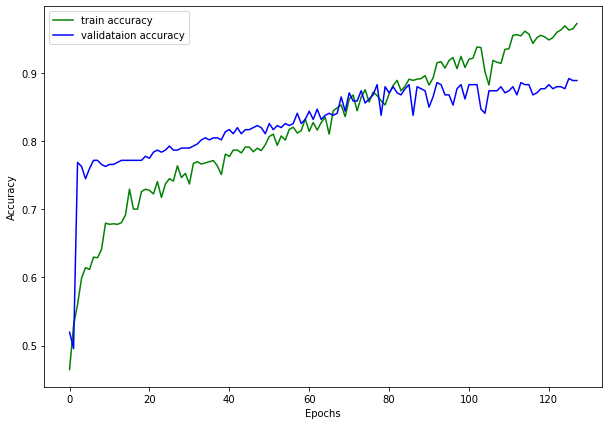

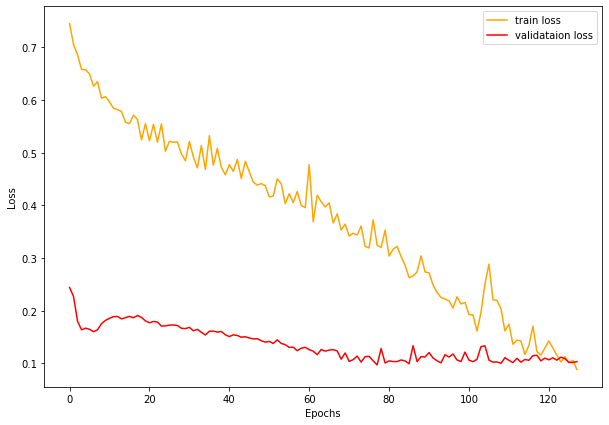

CPU times: user 6.26 s, sys: 167 ms, total: 6.43 s
Wall time: 6.76 s


In [25]:
%%time
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model=model_bcewl, criterion=criterion, optimizer=optimizer, n_epochs=n_epochs
                                                                                     , train_loader=train_loader, validation_loader=validation_loader
                                                                                     , lr_scheduler=lr_scheduler, early_stopper=early_stopper
                                                                                     , pos_label=1, threshold=threshold)


print('\nSaving loss and accuracy plots...')
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracies, color='green', label='train accuracy')
plt.plot(validation_accuracies, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("{}/figures/Accuracies by epoch".format(ROOT_DIR))
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='orange', label='train loss')
plt.plot(validation_losses, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("{}/figures/Losses by epoch".format(ROOT_DIR))
plt.show()

In [26]:
model_bcewl.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train      = model_bcewl(X_train)
y_pred_validation = model_bcewl(X_validation)
y_pred_test       = model_bcewl(X_test)

# criterion(y_pred_train, y_train), criterion(y_pred_validation, y_validation).item(), criterion(y_pred_test, y_test).item()
"Train: {}".format(torch.mean(( y_validation - torch.sigmoid(y_pred_validation) )**2).item()), "Validation: {}".format(torch.mean(( y_validation - torch.sigmoid(y_pred_validation) )**2).item()), "Test: {}".format(torch.mean(( y_test - torch.sigmoid(y_pred_test) )**2).item())

('Train: 0.1087377518415451',
 'Validation: 0.1087377518415451',
 'Test: 0.1619538813829422')

In [27]:
train_results      = return_binary_class_labels(predictions=y_pred_train, threshold=threshold, pos_label=pos_label)
validation_results = return_binary_class_labels(predictions=y_pred_validation, threshold=threshold, pos_label=pos_label)
test_results       = return_binary_class_labels(predictions=y_pred_test, threshold=threshold, pos_label=pos_label)
# train_results, y_train

#### Compute confusion matrix and accuray

In [28]:
confmat = ConfusionMatrix(num_classes=2)
cmat_train      = confmat(train_results.to('cpu'), y_train.int().to('cpu'))
cmat_validation = confmat(validation_results.to('cpu'), y_validation.int().to('cpu'))
cmat_test       = confmat(test_results.to('cpu'), y_test.int().to('cpu'))
accuracy = Accuracy(num_classes=2)
accuracy_train      = accuracy(train_results.int().to('cpu'), y_train.int().to('cpu'))
accuracy_validation = accuracy(validation_results.int().to('cpu'), y_validation.int().to('cpu'))
accuracy_test       = accuracy(test_results.int().to('cpu'), y_test.int().to('cpu'))


# "Train: {}".format(cmat_train), "Validation: {}".format(cmat_validation), "Test: {}".format(cmat_test)
"Train", cmat_train, "Validation", cmat_validation, "Test", cmat_test, "Train: {} - Validation: {} - Test: {}".format(round(float(accuracy_train), 3)
                                               , round(float(accuracy_validation), 3)
                                               ,  round(float(accuracy_test), 3))

('Train',
 tensor([[657,   8],
         [  4, 495]]),
 'Validation',
 tensor([[142,  14],
         [ 23, 154]]),
 'Test',
 tensor([[76, 12],
         [16, 62]]),
 'Train: 0.99 - Validation: 0.889 - Test: 0.831')

\
The results are very similar in terms of loss and statistics. \
We have used early stopping and learning rate scheduling. Feel free to set disable either feature by seeting it to None. Instead of using early stopping or schedule the learning rate, one can use certain optimizers such as the **Adam optimizer** that already implements a learning rate scheduling approach. However, it does not always outperforms. However, it can cause model divergence.

## Using the Adam optimizer, and BCEWithLogitsLoss function

In [29]:
X_train       = np.stack(compounds_train.FPs.values)
y_train       = compounds_train.activity.values.reshape((-1,1))
X_validation  = np.stack(compounds_validation.FPs.values)
y_validation  = compounds_validation.activity.values.reshape((-1,1))
X_test        = np.stack(compounds_test.FPs.values)
y_test        = compounds_test.activity.values.reshape((-1,1))
X_train.shape, X_validation.shape, X_test.shape

X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [30]:
criterion = nn.BCEWithLogitsLoss() # De facto for binary classification
model_bcewl = ActivityNet(n_inputs, hidden_size, dropout_rate, output_size, squash_output=False).to(device=device) # Returns a Tensor with the specified device
optimizer = optim.Adam(model_bcewl.parameters(), lr=learning_rate)
threshold    = torch.tensor([0.0]).to(device)
early_stopper = EarlyStopping(min_delta=0.00001, patience = es_patience)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5
                                 , patience=lr_patience # Number of epochs with no improvement after which learning rate will be reduced
                                 , verbose=True
                                 , threshold=0.0001
                                 , threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

Training:   1%|          | 4/500 [00:00<00:30, 16.27it/s]

Epoch:   0 Training loss: 0.63 Validation loss: 0.19
Epoch:   0 Training accuracy: 0.64 Validation accuracy: 0.78
INFO: Early stopping counter 1 of 50


Training:   2%|▏         | 8/500 [00:00<00:30, 16.27it/s]

INFO: Early stopping counter 2 of 50
INFO: Early stopping counter 3 of 50
INFO: Early stopping counter 4 of 50
INFO: Early stopping counter 5 of 50


Training:   2%|▏         | 12/500 [00:00<00:30, 16.25it/s]

INFO: Early stopping counter 6 of 50
INFO: Early stopping counter 7 of 50
INFO: Early stopping counter 8 of 50
Epoch:  10 Training loss: 0.01 Validation loss: 0.15
Epoch:  10 Training accuracy: 1.00 Validation accuracy: 0.84
INFO: Early stopping counter 9 of 50


Training:   3%|▎         | 16/500 [00:00<00:29, 16.24it/s]

INFO: Early stopping counter 10 of 50
INFO: Early stopping counter 11 of 50
INFO: Early stopping counter 12 of 50
INFO: Early stopping counter 13 of 50


Training:   4%|▍         | 20/500 [00:01<00:29, 16.18it/s]

INFO: Early stopping counter 14 of 50
INFO: Early stopping counter 15 of 50
INFO: Early stopping counter 16 of 50
INFO: Early stopping counter 17 of 50


Training:   5%|▍         | 24/500 [00:01<00:29, 16.20it/s]

INFO: Early stopping counter 18 of 50
Epoch:  20 Training loss: 0.01 Validation loss: 0.15
Epoch:  20 Training accuracy: 1.00 Validation accuracy: 0.84
INFO: Early stopping counter 19 of 50
INFO: Early stopping counter 20 of 50
INFO: Early stopping counter 21 of 50


Training:   6%|▌         | 28/500 [00:01<00:29, 16.04it/s]

INFO: Early stopping counter 22 of 50
INFO: Early stopping counter 23 of 50
INFO: Early stopping counter 24 of 50
INFO: Early stopping counter 25 of 50


Training:   6%|▋         | 32/500 [00:01<00:28, 16.16it/s]

INFO: Early stopping counter 26 of 50
INFO: Early stopping counter 27 of 50
INFO: Early stopping counter 28 of 50
Epoch:  30 Training loss: 0.00 Validation loss: 0.15
Epoch:  30 Training accuracy: 1.00 Validation accuracy: 0.85
INFO: Early stopping counter 29 of 50


Training:   7%|▋         | 36/500 [00:02<00:28, 16.21it/s]

INFO: Early stopping counter 30 of 50
INFO: Early stopping counter 31 of 50
INFO: Early stopping counter 32 of 50
INFO: Early stopping counter 33 of 50


Training:   8%|▊         | 38/500 [00:02<00:28, 16.22it/s]

INFO: Early stopping counter 34 of 50
INFO: Early stopping counter 35 of 50
INFO: Early stopping counter 36 of 50


Training:   8%|▊         | 40/500 [00:02<00:29, 15.42it/s]

INFO: Early stopping counter 37 of 50
INFO: Early stopping counter 38 of 50
Epoch:  40 Training loss: 0.00 Validation loss: 0.15
Epoch:  40 Training accuracy: 1.00 Validation accuracy: 0.85


Training:   9%|▉         | 44/500 [00:02<00:32, 13.92it/s]

INFO: Early stopping counter 39 of 50
INFO: Early stopping counter 40 of 50
INFO: Early stopping counter 41 of 50
INFO: Early stopping counter 42 of 50


Training:  10%|▉         | 48/500 [00:03<00:30, 14.94it/s]

INFO: Early stopping counter 43 of 50
INFO: Early stopping counter 44 of 50
INFO: Early stopping counter 45 of 50
INFO: Early stopping counter 46 of 50


Training:  10%|█         | 52/500 [00:03<00:29, 15.41it/s]

INFO: Early stopping counter 47 of 50
INFO: Early stopping counter 48 of 50
Epoch:  50 Training loss: 0.00 Validation loss: 0.15
Epoch:  50 Training accuracy: 1.00 Validation accuracy: 0.85
INFO: Early stopping counter 49 of 50
INFO: Early stopping counter 50 of 50
INFO: Early stopping

Saving loss and accuracy plots...


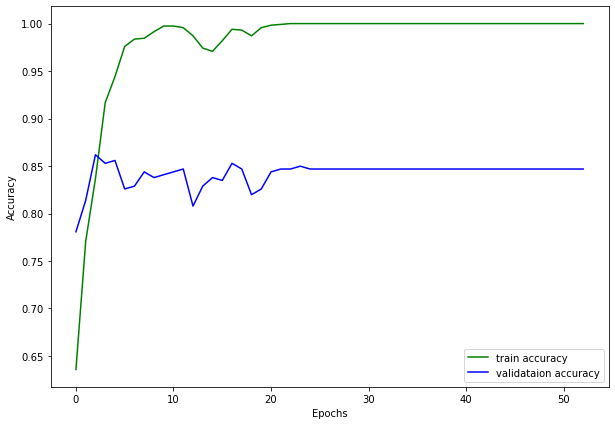

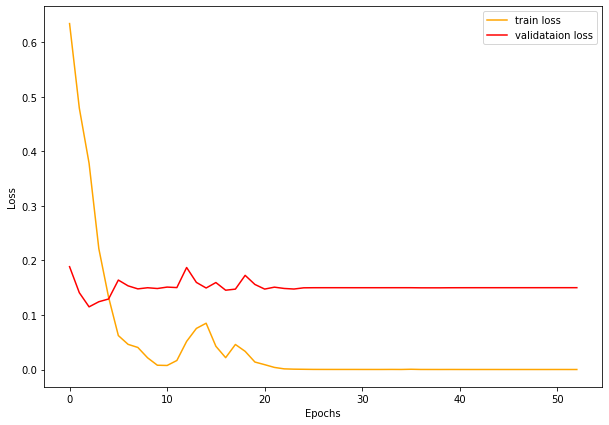

CPU times: user 3.73 s, sys: 149 ms, total: 3.88 s
Wall time: 3.89 s


In [31]:
%%time
train_losses, validation_losses, train_accuracies, validation_accuracies = train_model(model=model_bcewl, criterion=criterion, optimizer=optimizer, n_epochs=n_epochs
                                                                                     , train_loader=train_loader, validation_loader=validation_loader
                                                                                     , lr_scheduler=None, early_stopper=early_stopper
                                                                                     , pos_label=1, threshold=threshold)


print('\nSaving loss and accuracy plots...')
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracies, color='green', label='train accuracy')
plt.plot(validation_accuracies, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("{}/figures/Accuracies by epoch".format(ROOT_DIR))
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='orange', label='train loss')
plt.plot(validation_losses, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("{}/figures/Losses by epoch".format(ROOT_DIR))
plt.show()

In [32]:
model_bcewl.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train      = model_bcewl(X_train)
y_pred_validation = model_bcewl(X_validation)
y_pred_test       = model_bcewl(X_test)

# criterion(y_pred_train, y_train), criterion(y_pred_validation, y_validation).item(), criterion(y_pred_test, y_test).item()
"Train: {}".format(torch.mean(( y_validation - torch.sigmoid(y_pred_validation) )**2).item()), "Validation: {}".format(torch.mean(( y_validation - torch.sigmoid(y_pred_validation) )**2).item()), "Test: {}".format(torch.mean(( y_test - torch.sigmoid(y_pred_test) )**2).item())

('Train: 0.15314322710037231',
 'Validation: 0.15314322710037231',
 'Test: 0.17452114820480347')

In [33]:
train_results      = return_binary_class_labels(predictions=y_pred_train, threshold=threshold, pos_label=pos_label)
validation_results = return_binary_class_labels(predictions=y_pred_validation, threshold=threshold, pos_label=pos_label)
test_results       = return_binary_class_labels(predictions=y_pred_test, threshold=threshold, pos_label=pos_label)
# train_results, y_train

#### Compute confusion matrix and accuray

In [34]:
confmat = ConfusionMatrix(num_classes=2)
cmat_train      = confmat(train_results.to('cpu'), y_train.int().to('cpu'))
cmat_validation = confmat(validation_results.to('cpu'), y_validation.int().to('cpu'))
cmat_test       = confmat(test_results.to('cpu'), y_test.int().to('cpu'))
accuracy = Accuracy(num_classes=2)
accuracy_train      = accuracy(train_results.int().to('cpu'), y_train.int().to('cpu'))
accuracy_validation = accuracy(validation_results.int().to('cpu'), y_validation.int().to('cpu'))
accuracy_test       = accuracy(test_results.int().to('cpu'), y_test.int().to('cpu'))


# "Train: {}".format(cmat_train), "Validation: {}".format(cmat_validation), "Test: {}".format(cmat_test)
"Train", cmat_train, "Validation", cmat_validation, "Test", cmat_test, "Train: {} - Validation: {} - Test: {}".format(round(float(accuracy_train), 3)
                                               , round(float(accuracy_validation), 3)
                                               ,  round(float(accuracy_test), 3))

('Train',
 tensor([[665,   0],
         [  0, 499]]),
 'Validation',
 tensor([[127,  29],
         [ 22, 155]]),
 'Test',
 tensor([[72, 16],
         [13, 65]]),
 'Train: 1.0 - Validation: 0.847 - Test: 0.825')